In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cv2


import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))

from lib_MHDPIC1D.pic1d import *
from lib_MHDPIC1D.mhd1d import *
from lib_MHDPIC1D.interface import *
from lib_MHDPIC1D.remove_noise import *

shock tube

PIC初期化

In [70]:
c = 1.0
mu_0 = 1.0
epsilon0 = 1.0 / (mu_0 * c**2)
m_electron = 1.0
r_m = 1 / 100
m_ion = m_electron / r_m
t_r = 1.0
ne0_pic = 200 #ここは手動で調整すること
ni0_pic = ne0_pic
B0_pic = np.sqrt(ne0_pic) / 4.0
Te_pic = 0.5 * m_electron * (0.1*c)**2
Ti_pic = Te_pic / t_r
q_electron = -1 * np.sqrt(epsilon0 * Te_pic / ne0_pic)
q_ion = -1 * q_electron
debye_length = np.sqrt(epsilon0 * Te_pic / ne0_pic / q_electron**2)
omega_pe = np.sqrt(ne0_pic * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(ni0_pic * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0_pic / m_electron
omega_ci = q_ion * B0_pic / m_ion
VA_pic = B0_pic / np.sqrt(ni0_pic * m_ion + ni0_pic * m_electron)
gamma_pic = 5.0 / 3.0
rho_pic = ni0_pic * m_ion + ne0_pic * m_electron
p_pic = ni0_pic * Ti_pic + ne0_pic * Te_pic
CS_pic = np.sqrt(gamma_pic * p_pic / rho_pic)
v_thermal_electron = np.sqrt(2.0 * Te_pic / m_electron)
v_thermal_ion = np.sqrt(2.0 * Ti_pic / m_ion)
ion_inertial_length = c / omega_pi

ni0L_pic = ni0_pic
ne0L_pic = ne0_pic
ni0R_pic = int(ni0_pic * 0.125) #注意
ne0R_pic = int(ne0_pic * 0.125) #注意
bulk_vL = np.array([0.0, 0.0, 0.0])
bulk_vR = np.array([0.0, 0.0, 0.0])
BL = B0_pic * np.array([0.75, 1.0, 0.0])
BR = B0_pic * np.array([0.75, -1.0, 0.0])
TiL_pic = Ti_pic
TeL_pic = Te_pic
TiR_pic = TiL_pic * (ni0L_pic + t_r * ne0L_pic) * 0.1/1.0 / (ni0R_pic + t_r * ne0R_pic)
TeR_pic = TeL_pic * (ni0L_pic + t_r * ne0L_pic) * 0.1/1.0 / (ni0R_pic + t_r * ne0R_pic)
v_thermal_ionL = np.sqrt(2.0 * TiL_pic / m_ion)
v_thermal_electronL = np.sqrt(2.0 * TeL_pic / m_electron)
v_thermal_ionR = np.sqrt(2.0 * TiR_pic / m_ion)
v_thermal_electronR = np.sqrt(2.0 * TeR_pic / m_electron)

dx_pic = debye_length
nx_pic = 400
x_min_pic = 1e-10
x_max_pic = nx_pic * dx_pic - 1e-10
x_coordinate_pic = np.arange(0.0, x_max_pic, dx_pic)
dt_pic = 0.0
d_pic = 0.0

E_pic = np.zeros([3, nx_pic])
B_pic = np.zeros([3, nx_pic])
current_pic = np.zeros([3, nx_pic])
rho_pic = np.zeros(nx_pic)
B_pic[0, :int(nx_pic/2)] = BL[0]
B_pic[0, int(nx_pic/2):] = BR[0]
B_pic[1, :int(nx_pic/2)] = BL[1]
B_pic[1, int(nx_pic/2):] = BR[1]
B_pic[2, :int(nx_pic/2)] = BL[2]
B_pic[2, int(nx_pic/2):] = BR[2]
E_pic[0, :] = 0.0
E_pic[1, :] = 0.0
E_pic[2, :] = 0.0

n_ionL = int(ni0L_pic * nx_pic / 2)
n_ionR = int(ni0R_pic * nx_pic / 2)
n_electronL = int(ne0L_pic * nx_pic / 2)
n_electronR = int(ne0R_pic * nx_pic / 2)
n_ion = n_ionL + n_ionR
n_electron = n_electronL + n_electronR
x_pic_ion = np.zeros([3, n_ion])
x_pic_electron = np.zeros([3, n_electron])
v_pic_ion = np.zeros([3, n_ion])
v_pic_electron = np.zeros([3, n_electron])

rs_ion = np.random.RandomState(10)
rs_electron = np.random.RandomState(20)
for i in range(0, int(nx_pic/2), 1):
    x_pic_ion[0, i * ni0L_pic : (i+1) * ni0L_pic] = (rs_ion.rand(ni0L_pic) + i) * dx_pic
    x_pic_electron[0, i * ne0L_pic : (i+1) * ne0L_pic] = (rs_electron.rand(ne0L_pic) + i) * dx_pic
    
    v_pic_ion[0, i * ni0L_pic : (i+1) * ni0L_pic] = np.asarray(stats.norm.rvs(bulk_vL[0], v_thermal_ionL, size=ni0L_pic, random_state=30+(i+1)*nx_pic))
    v_pic_ion[1, i * ni0L_pic : (i+1) * ni0L_pic] = np.asarray(stats.norm.rvs(bulk_vL[1], v_thermal_ionL, size=ni0L_pic, random_state=40+(i+1)*nx_pic))
    v_pic_ion[2, i * ni0L_pic : (i+1) * ni0L_pic] = np.asarray(stats.norm.rvs(bulk_vL[2], v_thermal_ionL, size=ni0L_pic, random_state=50+(i+1)*nx_pic))
    v_pic_electron[0, i * ne0L_pic : (i+1) * ne0L_pic] = np.asarray(stats.norm.rvs(bulk_vL[0], v_thermal_electronL, size=ne0L_pic, random_state=60+(i+1)*nx_pic))
    v_pic_electron[1, i * ne0L_pic : (i+1) * ne0L_pic] = np.asarray(stats.norm.rvs(bulk_vL[1], v_thermal_electronL, size=ne0L_pic, random_state=70+(i+1)*nx_pic))
    v_pic_electron[2, i * ne0L_pic : (i+1) * ne0L_pic] = np.asarray(stats.norm.rvs(bulk_vL[2], v_thermal_electronL, size=ne0L_pic, random_state=80+(i+1)*nx_pic))

for i in range(0, int(nx_pic/2), 1):
    x_pic_ion[0, n_ionL + i * ni0R_pic : n_ionL + (i+1) * ni0R_pic] = nx_pic * dx_pic / 2.0 + (rs_ion.rand(ni0R_pic) + i) * dx_pic
    x_pic_electron[0, n_electronL + i * ne0R_pic : n_electronL + (i+1) * ne0R_pic] = nx_pic * dx_pic / 2.0 + (rs_electron.rand(ne0R_pic) + i) * dx_pic
    
    v_pic_ion[0, n_ionL + i * ni0R_pic : n_ionL + (i+1) * ni0R_pic] = np.asarray(stats.norm.rvs(bulk_vR[0], v_thermal_ionR, size=ni0R_pic, random_state=30+(i+1)*nx_pic))
    v_pic_ion[1, n_ionL + i * ni0R_pic : n_ionL + (i+1) * ni0R_pic] = np.asarray(stats.norm.rvs(bulk_vR[1], v_thermal_ionR, size=ni0R_pic, random_state=40+(i+1)*nx_pic))
    v_pic_ion[2, n_ionL + i * ni0R_pic : n_ionL + (i+1) * ni0R_pic] = np.asarray(stats.norm.rvs(bulk_vR[2], v_thermal_ionR, size=ni0R_pic, random_state=50+(i+1)*nx_pic))
    v_pic_electron[0, n_electronL + i * ne0R_pic : n_electronL + (i+1) * ne0R_pic] = np.asarray(stats.norm.rvs(bulk_vR[0], v_thermal_electronR, size=ne0R_pic, random_state=60+(i+1)*nx_pic))
    v_pic_electron[1, n_electronL + i * ne0R_pic : n_electronL + (i+1) * ne0R_pic] = np.asarray(stats.norm.rvs(bulk_vR[1], v_thermal_electronR, size=ne0R_pic, random_state=70+(i+1)*nx_pic))
    v_pic_electron[2, n_electronL + i * ne0R_pic : n_electronL + (i+1) * ne0R_pic] = np.asarray(stats.norm.rvs(bulk_vR[2], v_thermal_electronR, size=ne0R_pic, random_state=80+(i+1)*nx_pic))


print(f"total number of particles is {n_ion + n_electron}.")
print(f"Box size is {nx_pic}")
print(f"ion inertial length is {ion_inertial_length:.1f}")

total number of particles is 90000.
Box size is 400
ion inertial length is 141.4


In [71]:
ni0_pic * Ti_pic + ne0_pic * Te_pic, B0_pic**2 / 2

(2.0000000000000004, 6.250000000000001)

MHD初期化

In [72]:
gamma_mhd = 5.0 / 3.0
rho0_mhdL = ne0L_pic * m_electron + ni0L_pic * m_ion
rho0_mhdR = ne0R_pic * m_electron + ni0R_pic * m_ion
p0_mhdL = ne0L_pic * TeL_pic + ni0L_pic * TiL_pic
p0_mhdR = ne0R_pic * TeR_pic + ni0R_pic * TiR_pic
dx_mhd = dx_pic

nx_mhd = 350
x_min_mhd = 1e-10
x_max_mhd = nx_mhd * dx_mhd - 1e-10
dt_mhd = 0.0
CFL = 0.7
x_coordinate_mhd = np.arange(x_min_mhd, x_max_mhd, dx_mhd)

U1 = np.zeros([8, nx_mhd])
rho_init = rho0_mhdL
u_init = rho0_mhdL * bulk_vL[0]
v_init = rho0_mhdL * bulk_vL[1]
w_init = rho0_mhdL * bulk_vL[2]
Bx_init = BL[0]
By_init = BL[1]
Bz_init = BL[2]
p_init = p0_mhdL
U1[0, :] = rho_init
U1[1, :] = rho_init * u_init
U1[2, :] = rho_init * v_init
U1[3, :] = rho_init * w_init
U1[4, :] = Bx_init
U1[5, :] = By_init
U1[6, :] = Bz_init
U1[7, :] = p_init / (gamma_mhd - 1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

U2 = np.zeros([8, nx_mhd])
rho_init = rho0_mhdR
u_init = rho0_mhdR * bulk_vR[0]
v_init = rho0_mhdR * bulk_vR[1]
w_init = rho0_mhdR * bulk_vR[2]
Bx_init = BR[0]
By_init = BR[1]
Bz_init = BR[2]
p_init = p0_mhdR
U2[0, :] = rho_init
U2[1, :] = rho_init * u_init
U2[2, :] = rho_init * v_init
U2[3, :] = rho_init * w_init
U2[4, :] = Bx_init
U2[5, :] = By_init
U2[6, :] = Bz_init
U2[7, :] = p_init / (gamma_mhd - 1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

flux1 = np.zeros(U1.shape)
flux1_bar = np.zeros(flux1.shape)
flux2 = np.zeros(U2.shape)
flux2_bar = np.zeros(flux2.shape)

print(f"U1 size = {U1.shape}, U2 size = {U2.shape}")

U1 size = (8, 350), U2 size = (8, 350)


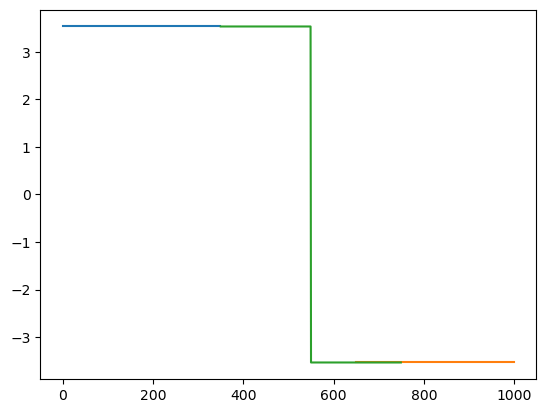

In [73]:
plt.plot(x_coordinate_mhd, U1[5, :])
plt.plot(x_coordinate_mhd + 650, U2[5, :])
plt.plot(x_coordinate_pic + 350, B_pic[1, :])

interface用の変数

In [74]:
window_size_convolution_pic = 10
window_size_smoothing_mhd = 5
interface_width = 50

index_interface_mhd_start_left = nx_mhd - interface_width
index_interface_mhd_end_left = nx_mhd
index_interface_mhd_start_right = 0
index_interface_mhd_end_right = interface_width
index_interface_pic_start_left = 0
index_interface_pic_end_left = interface_width
index_interface_pic_start_right = nx_pic - interface_width
index_interface_pic_end_right = nx_pic

x_interface_coordinate_left = np.arange(0, interface_width, 1)
x_interface_coordinate_half_left = np.arange(0.5, interface_width - 0.5, 1)
F_left = interlocking_function(x_interface_coordinate_left)
F_half_left = interlocking_function(x_interface_coordinate_half_left)
F_right = np.flip(F_left)
F_half_right = np.flip(F_half_left)

時間発展

In [75]:
#STEP1:PICとMHDの時間を合わせる
#以下、t1からt2に時間発展させるとする
#ただし、t2 = t1 + dt_mhdとする
B_pic_time_ave = np.zeros(B_pic.shape)
zeroth_moment_ion_time_ave = np.zeros(nx_pic)
zeroth_moment_electron_time_ave = np.zeros(nx_pic)
first_moment_ion_time_ave = np.zeros([3, nx_pic])
first_moment_electron_time_ave = np.zeros([3, nx_pic])
second_moment_ion_time_ave = np.zeros([9, nx_pic])
second_moment_electron_time_ave = np.zeros([9, nx_pic])

total_substeps = 10

dirname = "results_MS_shock_tube"
steps = 1000
time_mhd = 0.0
time_pic = 0.0
for step in range(steps+1):

    # save
    if (step % 10 == 0):
        print(f"{step} step done... : time_mhd = {time_mhd:.5f}, time_pic = {time_pic:.5f}, dt_mhd = {dt_mhd:.5f}, dt_pic = {dt_pic:.5f}")

        np.save(f'./{dirname}/x_ion_{step}.npy', x_pic_ion)
        np.save(f'./{dirname}/x_electron_{step}.npy', x_pic_electron)
        np.save(f'./{dirname}/v_ion_{step}.npy', v_pic_ion)
        np.save(f'./{dirname}/v_electron_{step}.npy', v_pic_electron)
        np.save(f'./{dirname}/E_{step}.npy', E_pic)
        np.save(f'./{dirname}/B_{step}.npy', B_pic)
        np.save(f'./{dirname}/current_{step}.npy', current_pic)
        np.save(f"./{dirname}/U1_{step}.npy", U1)
        np.save(f"./{dirname}/U2_{step}.npy", U2)

        zeroth_moment_ion = np.zeros(nx_pic)
        zeroth_moment_electron = np.zeros(nx_pic)
        zeroth_moment_ion = get_zeroth_moment(x_pic_ion, nx_pic, dx_pic, zeroth_moment_ion)
        zeroth_moment_electron = get_zeroth_moment(x_pic_electron, nx_pic, dx_pic, zeroth_moment_electron)
        first_moment_ion = np.zeros([3, nx_pic])
        first_moment_electron = np.zeros([3, nx_pic])
        first_moment_ion = get_first_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, first_moment_ion)
        first_moment_electron = get_first_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, first_moment_electron)
        second_moment_ion = np.zeros([9, nx_pic])
        second_moment_electron = np.zeros([9, nx_pic])
        second_moment_ion = get_second_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, second_moment_ion)
        second_moment_electron = get_second_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, second_moment_electron)

        np.save(f'./{dirname}/zeroth_moment_ion_{step}.npy', zeroth_moment_ion)
        np.save(f'./{dirname}/zeroth_moment_electron_{step}.npy', zeroth_moment_electron)
        np.save(f'./{dirname}/first_moment_ion_{step}.npy', first_moment_ion)
        np.save(f'./{dirname}/first_moment_electron_{step}.npy', first_moment_electron)
        np.save(f'./{dirname}/second_moment_ion_{step}.npy', second_moment_ion)
        np.save(f'./{dirname}/second_moment_electron_{step}.npy', second_moment_electron)

        np.save(f'./{dirname}/B_time_ave_{step}.npy', B_pic_time_ave)
        np.save(f'./{dirname}/zeroth_moment_ion_time_ave_{step}.npy', zeroth_moment_ion_time_ave)
        np.save(f'./{dirname}/zeroth_moment_electron_time_ave_{step}.npy', zeroth_moment_electron_time_ave)
        np.save(f'./{dirname}/first_moment_ion_time_ave_{step}.npy', first_moment_ion_time_ave)
        np.save(f'./{dirname}/first_moment_electron_time_ave_{step}.npy', first_moment_electron_time_ave)
        np.save(f'./{dirname}/second_moment_ion_time_ave_{step}.npy', second_moment_ion_time_ave)
        np.save(f'./{dirname}/second_moment_electron_time_ave_{step}.npy', second_moment_electron_time_ave)

    #STEP1:MHD-Predictor
    U1_past = U1.copy()
    U2_past = U2.copy()
    #MHD
    #----------------------------------------------------------- 
    if True:
        U1_bar = U1.copy()
        U2_bar = U2.copy()

        dt_mhd_left = get_time_step(U1, gamma_mhd, dx_mhd, CFL)
        dt_mhd_right = get_time_step(U2, gamma_mhd, dx_mhd, CFL)
        dt_mhd = np.min([dt_mhd_left, dt_mhd_right])
        if np.isnan(dt_mhd):
            print(f"{step} steps (t = {time_mhd:.3f}) : Calculation is crashed!")
            break

        flux1 = get_flux_mhd(U1, gamma_mhd, flux1)
        flux2 = get_flux_mhd(U2, gamma_mhd, flux2)
        U1_bar += -dt_mhd/dx_mhd * (flux1 - np.roll(flux1, 1, axis=1))
        U2_bar += -dt_mhd/dx_mhd * (flux2 - np.roll(flux2, 1, axis=1))
        U1_bar = boundary_symmetric_x(U1_bar)
        U2_bar = boundary_symmetric_x(U2_bar)

        flux1_bar = get_flux_mhd(U1_bar, gamma_mhd, flux1_bar)
        flux2_bar = get_flux_mhd(U2_bar, gamma_mhd, flux2_bar)
        flux1 = 0.5 * (flux1 + flux1_bar)
        flux2 = 0.5 * (flux2 + flux2_bar)
        U1 += -dt_mhd/dx_mhd * (flux1 - np.roll(flux1, 1, axis=1))
        U2 += -dt_mhd/dx_mhd * (flux2 - np.roll(flux2, 1, axis=1))
        U1 = boundary_symmetric_x(U1)
        U2 = boundary_symmetric_x(U2)


    #STEP2:PIC
    B_pic_time_ave = np.zeros(B_pic.shape)
    zeroth_moment_ion_time_ave = np.zeros(zeroth_moment_ion_time_ave.shape)
    zeroth_moment_electron_time_ave = np.zeros(zeroth_moment_electron_time_ave.shape)
    first_moment_ion_time_ave = np.zeros(first_moment_ion_time_ave.shape)
    first_moment_electron_time_ave = np.zeros(first_moment_electron_time_ave.shape)
    second_moment_ion_time_ave = np.zeros(second_moment_ion_time_ave.shape)
    second_moment_electron_time_ave = np.zeros(second_moment_electron_time_ave.shape)
    
    dt_pic = dt_mhd / total_substeps
    for substep in range(total_substeps):

        B_pic = time_evolution_B(E_pic, dx_pic, dt_pic/2, B_pic) 
        B_pic = boundary_B(B_pic)
        U1_send = U1_past * (total_substeps - (substep + 0.5)) / total_substeps \
                + U1 * (substep + 0.5) / total_substeps
        B_pic = send_MHD_to_PICinterface_B(
            index_interface_mhd_start_left, index_interface_mhd_end_left, 
            index_interface_pic_start_left, index_interface_pic_end_left, 
            F_left, F_half_left, 
            U1_send, window_size_convolution_pic, B_pic
        )
        U2_send = U2_past * (total_substeps - (substep + 0.5)) / total_substeps \
                + U2 * (substep + 0.5) / total_substeps
        B_pic = send_MHD_to_PICinterface_B(
            index_interface_mhd_start_right, index_interface_mhd_end_right, 
            index_interface_pic_start_right, index_interface_pic_end_right, 
            F_right, F_half_right, 
            U2_send, window_size_convolution_pic, B_pic
        )
        
        v_pic_ion = time_evolution_v(c, E_pic, B_pic, x_pic_ion, q_ion, m_ion, nx_pic, dx_pic, dt_pic, v_pic_ion)
        v_pic_electron = time_evolution_v(c, E_pic, B_pic, x_pic_electron, q_electron, m_electron, nx_pic, dx_pic, dt_pic, v_pic_electron)
        x_pic_ion = time_evolution_x(c, dt_pic/2, v_pic_ion, x_pic_ion)
        x_pic_electron = time_evolution_x(c, dt_pic/2, v_pic_electron, x_pic_electron)
        #とりあえず
        v_pic_ion, x_pic_ion = open_condition_x_left(v_pic_ion, x_pic_ion, x_min_pic)
        v_pic_ion, x_pic_ion = open_condition_x_right(v_pic_ion, x_pic_ion, x_max_pic)
        v_pic_electron, x_pic_electron = open_condition_x_left(v_pic_electron, x_pic_electron, x_min_pic)
        v_pic_electron, x_pic_electron = open_condition_x_right(v_pic_electron, x_pic_electron, x_max_pic)

        current_pic = np.zeros(current_pic.shape)
        current_pic = get_current_density(c, q_ion, v_pic_ion, x_pic_ion, nx_pic, dx_pic, current_pic)
        current_pic = get_current_density(c, q_electron, v_pic_electron, x_pic_electron, nx_pic, dx_pic, current_pic)
        current_pic[:, 0] = current_pic[:, 1]
        current_pic[:, -1] = current_pic[:, -2]
        U1_send = U1_past * (total_substeps - (substep + 0.5)) / total_substeps \
                + U1 * (substep + 0.5) / total_substeps
        current_pic = send_MHD_to_PICinterface_current(
            index_interface_mhd_start_left, index_interface_mhd_end_left, 
            index_interface_pic_start_left, index_interface_pic_end_left, 
            F_left, F_half_left, 
            U1_send, dx_mhd, window_size_convolution_pic, current_pic
        )
        U2_send = U2_past * (total_substeps - (substep + 0.5)) / total_substeps \
                + U2 * (substep + 0.5) / total_substeps
        current_pic = send_MHD_to_PICinterface_current(
            index_interface_mhd_start_right, index_interface_mhd_end_right, 
            index_interface_pic_start_right, index_interface_pic_end_right, 
            F_right, F_half_right, 
            U2_send, dx_mhd, window_size_convolution_pic, current_pic
        )
        
        B_pic = time_evolution_B(E_pic, dx_pic, dt_pic/2, B_pic)
        B_pic = boundary_B(B_pic)
        U1_send = U1_past * (total_substeps - (substep + 1.0)) / total_substeps \
                + U1 * (substep + 1.0) / total_substeps
        B_pic = send_MHD_to_PICinterface_B(
            index_interface_mhd_start_left, index_interface_mhd_end_left, 
            index_interface_pic_start_left, index_interface_pic_end_left, 
            F_left, F_half_left, 
            U1_send, window_size_convolution_pic, B_pic
        )
        U2_send = U2_past * (total_substeps - (substep + 1.0)) / total_substeps \
                + U2 * (substep + 1.0) / total_substeps
        B_pic = send_MHD_to_PICinterface_B(
            index_interface_mhd_start_right, index_interface_mhd_end_right, 
            index_interface_pic_start_right, index_interface_pic_end_right, 
            F_right, F_half_right, 
            U2_send, window_size_convolution_pic, B_pic
        )
        
        E_pic = time_evolution_E(B_pic, current_pic, c, epsilon0, dx_pic, dt_pic, E_pic)
        E_pic = boundary_E(E_pic)
        rho_pic = np.zeros(rho_pic.shape)
        rho_pic = get_rho(q_ion, x_pic_ion, nx_pic, dx_pic, rho_pic)
        rho_pic = get_rho(q_electron, x_pic_electron, nx_pic, dx_pic, rho_pic)
        rho_pic[0] = rho_pic[1]
        rho_pic[-1] = rho_pic[-2]
        E_pic = filter_E(rho_pic, dx_pic, dt_pic, d_pic, epsilon0, E_pic)
        U1_send = U1_past * (total_substeps - (substep + 1.0)) / total_substeps \
                + U1 * (substep + 1.0) / total_substeps
        E_pic = send_MHD_to_PICinterface_E(
            index_interface_mhd_start_left, index_interface_mhd_end_left, 
            index_interface_pic_start_left, index_interface_pic_end_left, 
            F_left, F_half_left, 
            U1_send, window_size_convolution_pic, E_pic
        )
        U2_send = U2_past * (total_substeps - (substep + 1.0)) / total_substeps \
                + U2 * (substep + 1.0) / total_substeps
        E_pic = send_MHD_to_PICinterface_E(
            index_interface_mhd_start_right, index_interface_mhd_end_right, 
            index_interface_pic_start_right, index_interface_pic_end_right, 
            F_right, F_half_right, 
            U2_send, window_size_convolution_pic, E_pic
        )
        
        x_pic_ion = time_evolution_x(c, dt_pic/2, v_pic_ion, x_pic_ion)
        x_pic_electron = time_evolution_x(c, dt_pic/2, v_pic_electron, x_pic_electron)
        #とりあえず
        v_pic_ion, x_pic_ion = open_condition_x_left(v_pic_ion, x_pic_ion, x_min_pic)
        v_pic_ion, x_pic_ion = open_condition_x_right(v_pic_ion, x_pic_ion, x_max_pic)
        v_pic_electron, x_pic_electron = open_condition_x_left(v_pic_electron, x_pic_electron, x_min_pic)
        v_pic_electron, x_pic_electron = open_condition_x_right(v_pic_electron, x_pic_electron, x_max_pic)
        U1_send = U1_past * (total_substeps - (substep + 1.0)) / total_substeps \
                + U1 * (substep + 1.0) / total_substeps
        v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron = send_MHD_to_PICinterface_particle(
            index_interface_mhd_start_left, index_interface_mhd_end_left, 
            index_interface_pic_start_left, index_interface_pic_end_left, 
            F_left, x_min_pic,  
            U1_send, dx_mhd, gamma_mhd, q_electron, 
            m_electron, m_ion, nx_pic, c, window_size_convolution_pic, 
            v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron
        )
        U2_send = U2_past * (total_substeps - (substep + 1.0)) / total_substeps \
                + U2 * (substep + 1.0) / total_substeps
        v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron = send_MHD_to_PICinterface_particle(
            index_interface_mhd_start_right, index_interface_mhd_end_right, 
            index_interface_pic_start_right, index_interface_pic_end_right, 
            F_right, x_min_pic,  
            U2_send, dx_mhd, gamma_mhd, q_electron, 
            m_electron, m_ion, nx_pic, c, window_size_convolution_pic, 
            v_pic_ion, v_pic_electron, x_pic_ion, x_pic_electron
        )

        time_pic += dt_pic


        # 時間平均のため
        if True:
            B_pic_time_ave += B_pic

            zeroth_moment_ion_tmp = np.zeros(zeroth_moment_ion_time_ave.shape)
            zeroth_moment_electron_tmp = np.zeros(zeroth_moment_electron_time_ave.shape)
            zeroth_moment_ion_tmp = get_zeroth_moment(x_pic_ion, nx_pic, dx_pic, zeroth_moment_ion_tmp)
            zeroth_moment_electron_tmp = get_zeroth_moment(x_pic_electron, nx_pic, dx_pic, zeroth_moment_electron_tmp)
            zeroth_moment_ion_time_ave += zeroth_moment_ion_tmp
            zeroth_moment_electron_time_ave += zeroth_moment_electron_tmp

            first_moment_ion_tmp = np.zeros(first_moment_ion_time_ave.shape)
            first_moment_electron_tmp = np.zeros(first_moment_electron_time_ave.shape)
            first_moment_ion_tmp = get_first_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, first_moment_ion_tmp)
            first_moment_electron_tmp = get_first_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, first_moment_electron_tmp)
            first_moment_ion_time_ave += first_moment_ion_tmp
            first_moment_electron_time_ave += first_moment_electron_tmp

            second_moment_ion_tmp = np.zeros(second_moment_ion_time_ave.shape)
            second_moment_electron_tmp = np.zeros(second_moment_electron_time_ave.shape)
            second_moment_ion_tmp = get_second_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, second_moment_ion_tmp)
            second_moment_electron_tmp = get_second_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, second_moment_electron_tmp)
            second_moment_ion_time_ave += second_moment_ion_tmp
            second_moment_electron_time_ave += second_moment_electron_tmp
            
    B_pic_time_ave /= total_substeps
    zeroth_moment_ion_time_ave /= total_substeps
    zeroth_moment_electron_time_ave /= total_substeps
    first_moment_ion_time_ave /= total_substeps
    first_moment_electron_time_ave /= total_substeps
    second_moment_ion_time_ave /= total_substeps
    second_moment_electron_time_ave /= total_substeps


    #STEP3:MHD-Correcter
    U1_PIC = np.zeros(U1.shape)
    U2_PIC = np.zeros(U2.shape)
    #n+1/2にする
    U1_PIC[:, :] = 0.5 * (U1_past[:, :] + U1[:, :])
    U2_PIC[:, :] = 0.5 * (U2_past[:, :] + U2[:, :])
    U1_PIC = send_PIC_to_MHDinterface(
        index_interface_mhd_start_left, index_interface_mhd_end_left, 
        index_interface_pic_start_left, index_interface_pic_end_left, 
        F_left, 
        gamma_mhd, m_electron, m_ion, nx_pic, B_pic_time_ave, 
        zeroth_moment_ion_time_ave, zeroth_moment_electron_time_ave, 
        first_moment_ion_time_ave, first_moment_electron_time_ave, 
        second_moment_ion_time_ave, second_moment_electron_time_ave, 
        window_size_convolution_pic, U1_PIC
    )
    U2_PIC = send_PIC_to_MHDinterface(
        index_interface_mhd_start_right, index_interface_mhd_end_right, 
        index_interface_pic_start_right, index_interface_pic_end_right, 
        F_right, 
        gamma_mhd, m_electron, m_ion, nx_pic, B_pic_time_ave, 
        zeroth_moment_ion_time_ave, zeroth_moment_electron_time_ave, 
        first_moment_ion_time_ave, first_moment_electron_time_ave, 
        second_moment_ion_time_ave, second_moment_electron_time_ave, 
        window_size_convolution_pic, U2_PIC
    )

    if True:
        U1 = U1_past.copy()
        U2 = U2_past.copy()
    
        flux1 = get_flux_mhd(U1_PIC, gamma_mhd, flux1)
        flux2 = get_flux_mhd(U2_PIC, gamma_mhd, flux2)
        U1 += -dt_mhd/dx_mhd * (flux1 - np.roll(flux1, 1, axis=1))
        U2 += -dt_mhd/dx_mhd * (flux2 - np.roll(flux2, 1, axis=1))
        U1 = boundary_symmetric_x(U1)
        U2 = boundary_symmetric_x(U2)
        
        time_mhd += dt_mhd


    #interface領域のスムージング処理
    U1 = smoothing_U_left(
        U1, index_interface_mhd_start_left, index_interface_mhd_end_left, 
        window_size_smoothing_mhd
    )
    U2 = smoothing_U_right(
        U2, index_interface_mhd_start_right, index_interface_mhd_end_right, 
        window_size_smoothing_mhd
    )



0 step done... : time_mhd = 0.00000, time_pic = 0.00000, dt_mhd = 0.00000, dt_pic = 0.00000
10 step done... : time_mhd = 78.76646, time_pic = 78.76646, dt_mhd = 7.86368, dt_pic = 0.78637
20 step done... : time_mhd = 157.09310, time_pic = 157.09310, dt_mhd = 7.80929, dt_pic = 0.78093
30 step done... : time_mhd = 234.81843, time_pic = 234.81843, dt_mhd = 7.73384, dt_pic = 0.77338
40 step done... : time_mhd = 312.81106, time_pic = 312.81106, dt_mhd = 7.80761, dt_pic = 0.78076
50 step done... : time_mhd = 390.35341, time_pic = 390.35341, dt_mhd = 7.74599, dt_pic = 0.77460
60 step done... : time_mhd = 468.68631, time_pic = 468.68631, dt_mhd = 7.87221, dt_pic = 0.78722
70 step done... : time_mhd = 547.38601, time_pic = 547.38601, dt_mhd = 7.86630, dt_pic = 0.78663
80 step done... : time_mhd = 625.96342, time_pic = 625.96342, dt_mhd = 7.85052, dt_pic = 0.78505
90 step done... : time_mhd = 704.37510, time_pic = 704.37510, dt_mhd = 7.82632, dt_pic = 0.78263
100 step done... : time_mhd = 781.904

KeyboardInterrupt: 

プロット

In [76]:
dirname = "results_MS_shock_tube/"
step = 100

B = np.load(f"{dirname}/B_{step}.npy")
E = np.load(f"{dirname}/E_{step}.npy")
current = np.load(f"{dirname}/current_{step}.npy")
x_pic_ion = np.load(f"{dirname}/x_ion_{step}.npy")
x_pic_electron = np.load(f"{dirname}/x_electron_{step}.npy")
v_pic_ion = np.load(f"{dirname}/v_ion_{step}.npy")
v_pic_electron = np.load(f"{dirname}/v_electron_{step}.npy")
zeroth_moment_ion = np.load(f"{dirname}/zeroth_moment_ion_{step}.npy")
zeroth_moment_electron = np.load(f"{dirname}/zeroth_moment_electron_{step}.npy")
first_moment_ion = np.load(f"{dirname}/first_moment_ion_{step}.npy")
first_moment_electron = np.load(f"{dirname}/first_moment_electron_{step}.npy")
second_moment_ion = np.load(f"{dirname}/second_moment_ion_{step}.npy")
second_moment_electron = np.load(f"{dirname}/second_moment_electron_{step}.npy")

B_time_ave = np.load(f"{dirname}/B_time_ave_{step}.npy")
zeroth_moment_ion_time_ave = np.load(f"{dirname}/zeroth_moment_ion_time_ave_{step}.npy")
zeroth_moment_electron_time_ave = np.load(f"{dirname}/zeroth_moment_electron_time_ave_{step}.npy")
first_moment_ion_time_ave = np.load(f"{dirname}/first_moment_ion_time_ave_{step}.npy")
first_moment_electron_time_ave = np.load(f"{dirname}/first_moment_electron_time_ave_{step}.npy")
second_moment_ion_time_ave = np.load(f"{dirname}/second_moment_ion_time_ave_{step}.npy")
second_moment_electron_time_ave = np.load(f"{dirname}/second_moment_electron_time_ave_{step}.npy")

U1 = np.load(f"{dirname}/U1_{step}.npy")
rho1_mhd = U1[0, :]
u1_mhd = U1[1, :] / rho1_mhd
v1_mhd = U1[2, :] / rho1_mhd
w1_mhd = U1[3, :] / rho1_mhd
Bx1_mhd = U1[4, :]
By1_mhd = U1[5, :]
Bz1_mhd = U1[6, :]
e1_mhd = U1[7, :]
p1_mhd = (gamma_mhd - 1.0) \
        * (e1_mhd - 0.5 * rho1_mhd * (u1_mhd**2+v1_mhd**2+w1_mhd**2)
            - 0.5 * (Bx1_mhd**2+By1_mhd**2+Bz1_mhd**2))
Ex1_mhd = -(v1_mhd * Bz1_mhd - w1_mhd * By1_mhd)
Ey1_mhd = -(w1_mhd * Bx1_mhd - u1_mhd * Bz1_mhd)
Ez1_mhd = -(u1_mhd * By1_mhd - v1_mhd * Bx1_mhd)
current1_x_mhd = np.zeros(Bx1_mhd.shape)
current1_y_mhd = -(np.roll(Bz1_mhd, -1, axis=0) - np.roll(Bz1_mhd, 1, axis=0)) / (2*dx_mhd)
current1_z_mhd = (np.roll(By1_mhd, -1, axis=0) - np.roll(By1_mhd, 1, axis=0)) / (2*dx_mhd)
current1_y_mhd[0] = current1_y_mhd[1] 
current1_y_mhd[-1] = current1_y_mhd[-2] 
current1_z_mhd[0] = current1_z_mhd[1] 
current1_z_mhd[-1] = current1_z_mhd[-2] 

U2 = np.load(f"{dirname}/U2_{step}.npy")
rho2_mhd = U2[0, :]
u2_mhd = U2[1, :] / rho2_mhd
v2_mhd = U2[2, :] / rho2_mhd
w2_mhd = U2[3, :] / rho2_mhd
Bx2_mhd = U2[4, :]
By2_mhd = U2[5, :]
Bz2_mhd = U2[6, :]
e2_mhd = U2[7, :]
p2_mhd = (gamma_mhd - 1.0) \
        * (e2_mhd - 0.5 * rho2_mhd * (u2_mhd**2+v2_mhd**2+w2_mhd**2)
            - 0.5 * (Bx2_mhd**2+By2_mhd**2+Bz2_mhd**2))
Ex2_mhd = -(v2_mhd * Bz2_mhd - w2_mhd * By2_mhd)
Ey2_mhd = -(w2_mhd * Bx2_mhd - u2_mhd * Bz2_mhd)
Ez2_mhd = -(u2_mhd * By2_mhd - v2_mhd * Bx2_mhd)
current2_x_mhd = np.zeros(Bx2_mhd.shape)
current2_y_mhd = -(np.roll(Bz2_mhd, -1, axis=0) - np.roll(Bz2_mhd, 1, axis=0)) / (2*dx_mhd)
current2_z_mhd = (np.roll(By2_mhd, -1, axis=0) - np.roll(By2_mhd, 1, axis=0)) / (2*dx_mhd)
current2_y_mhd[0] = current2_y_mhd[1] 
current2_y_mhd[-1] = current2_y_mhd[-2] 
current2_z_mhd[0] = current2_z_mhd[1] 
current2_z_mhd[-1] = current2_z_mhd[-2] 

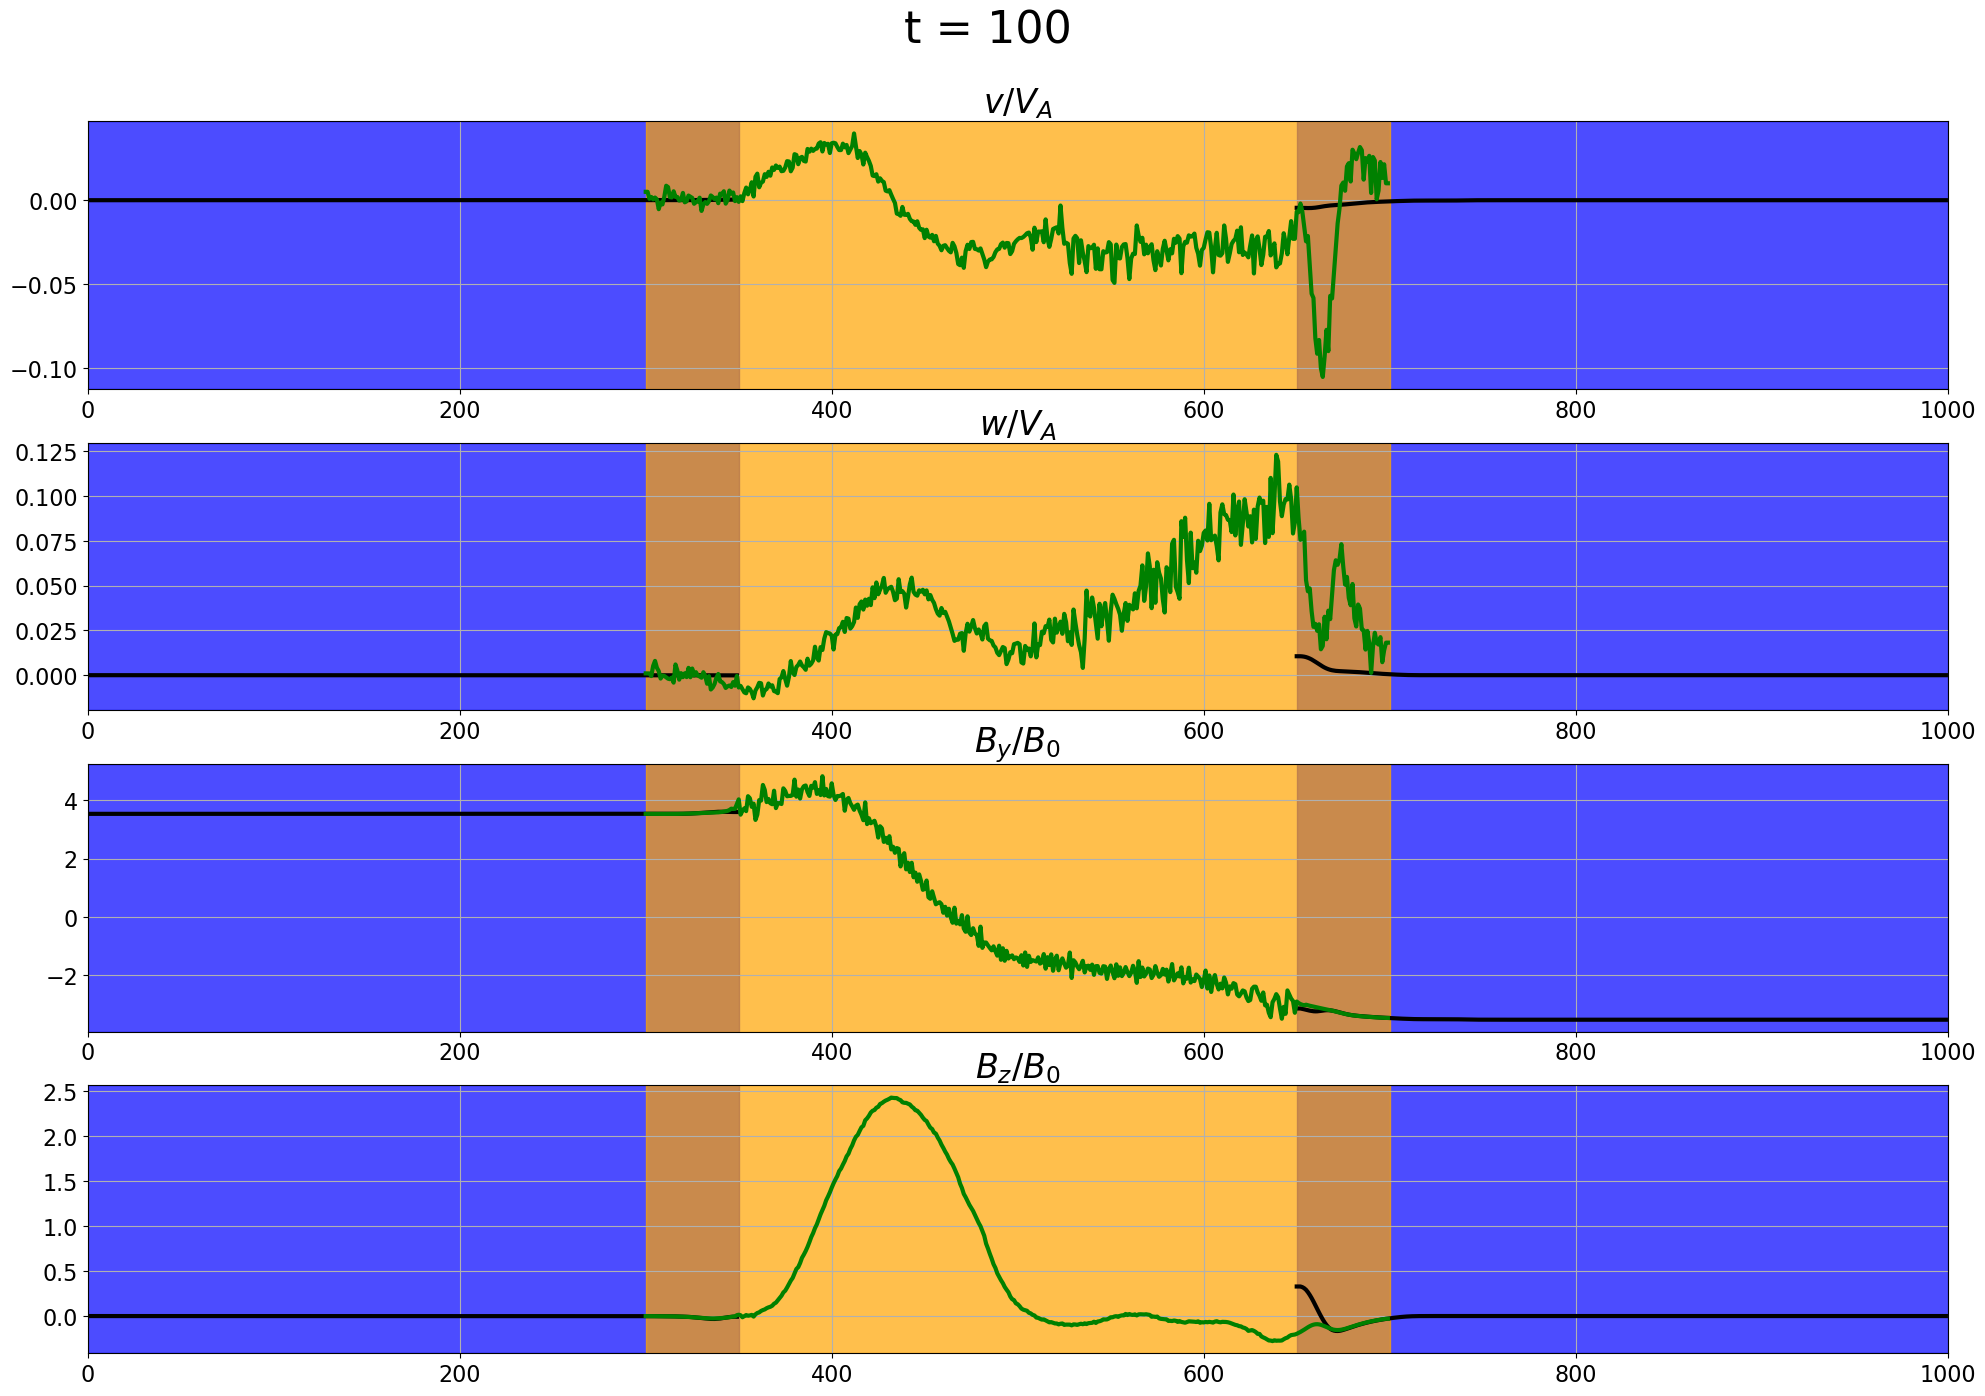

In [77]:
fig = plt.figure(figsize=(24, 16))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

bulk_vy_pic = (first_moment_ion[1, :] + first_moment_electron[1, :]) / (zeroth_moment_ion + zeroth_moment_electron + 1e-10)
bulk_vz_pic = (first_moment_ion[2, :] + first_moment_electron[2, :]) / (zeroth_moment_ion + zeroth_moment_electron + 1e-10)

ax1.plot(x_coordinate_mhd, v1_mhd, color='black', lw=3)
ax2.plot(x_coordinate_mhd, w1_mhd, color='black', lw=3)
ax3.plot(x_coordinate_mhd, By1_mhd, color='black', lw=3)
ax4.plot(x_coordinate_mhd, Bz1_mhd, color='black', lw=3)
ax1.plot(x_coordinate_mhd + 650, v2_mhd, color='black', lw=3)
ax2.plot(x_coordinate_mhd + 650, w2_mhd, color='black', lw=3)
ax3.plot(x_coordinate_mhd + 650, By2_mhd, color='black', lw=3)
ax4.plot(x_coordinate_mhd + 650, Bz2_mhd, color='black', lw=3)
ax1.plot(x_coordinate_pic + 300, bulk_vy_pic, color='green', lw=3)
ax2.plot(x_coordinate_pic + 300, bulk_vz_pic, color='green', lw=3)
ax3.plot(x_coordinate_pic + 300, B[1, :], color='green', lw=3)
ax4.plot(x_coordinate_pic + 300, B[2, :], color='green', lw=3)

ax1.axvspan(0, 350, color='blue', alpha=0.7)
ax2.axvspan(0, 350, color='blue', alpha=0.7)
ax3.axvspan(0, 350, color='blue', alpha=0.7)
ax4.axvspan(0, 350, color='blue', alpha=0.7)
ax1.axvspan(650, 1000, color='blue', alpha=0.7)
ax2.axvspan(650, 1000, color='blue', alpha=0.7)
ax3.axvspan(650, 1000, color='blue', alpha=0.7)
ax4.axvspan(650, 1000, color='blue', alpha=0.7)
ax1.axvspan(300, 700, color='orange', alpha=0.7)
ax2.axvspan(300, 700, color='orange', alpha=0.7)
ax3.axvspan(300, 700, color='orange', alpha=0.7)
ax4.axvspan(300, 700, color='orange', alpha=0.7)

ax1.set_title(r"$v / V_A$", fontsize=24)
ax2.set_title(r"$w / V_A$", fontsize=24)
ax3.set_title(r"$B_y / B_0$", fontsize=24)
ax4.set_title(r"$B_z / B_0$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax1.set_xlim(0, 1000)
ax2.set_xlim(0, 1000)
ax3.set_xlim(0, 1000)
ax4.set_xlim(0, 1000)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

plt.suptitle(f"t = {step}", y=0.95, fontsize=32)

plt.show()

動画作成

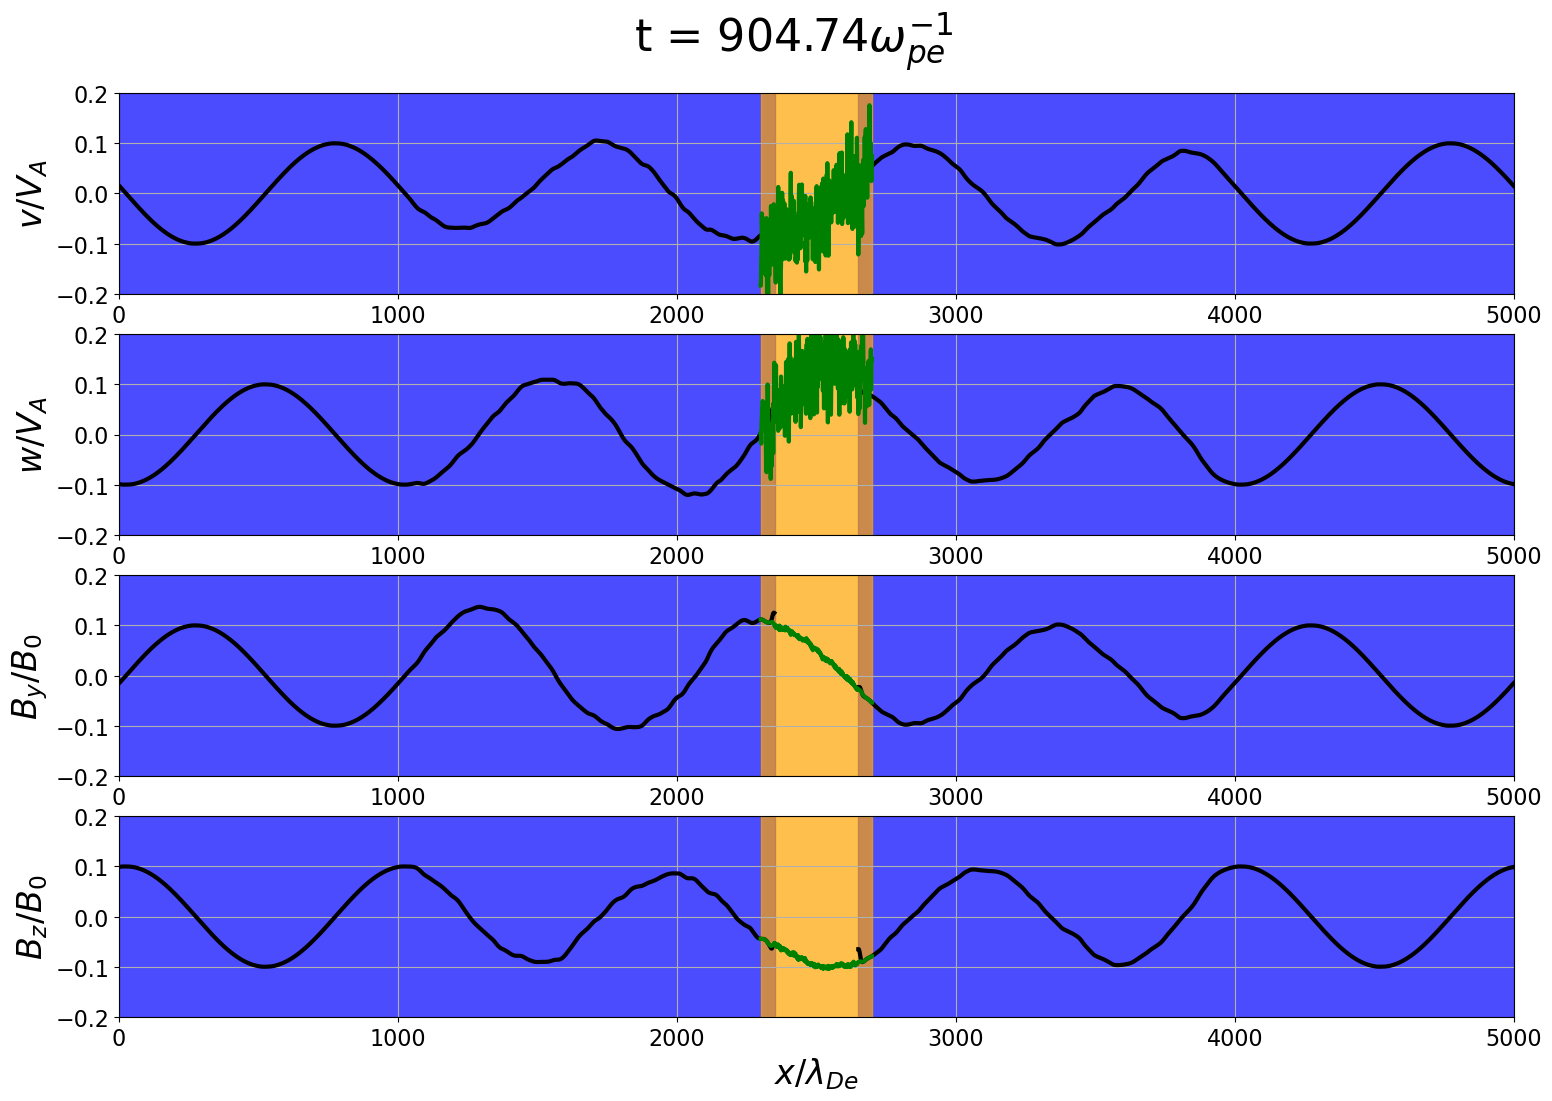

In [26]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

dirname = "results_MS_alfven"
filename = "Alfven_MHD-PIC.mp4"
log = np.loadtxt('log.txt', dtype=str)

interval = 10
plot_steps = 2000
for step in range(0, plot_steps+1, interval):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()

    B = np.load(f"{dirname}/B_{step}.npy")
    zeroth_moment_ion = np.load(f"{dirname}/zeroth_moment_ion_{step}.npy")
    zeroth_moment_electron = np.load(f"{dirname}/zeroth_moment_electron_{step}.npy")
    first_moment_ion = np.load(f"{dirname}/first_moment_ion_{step}.npy")
    first_moment_electron = np.load(f"{dirname}/first_moment_electron_{step}.npy")

    U1 = np.load(f"{dirname}/U1_{step}.npy")
    rho1_mhd = U1[0, :]
    u1_mhd = U1[1, :] / rho1_mhd
    v1_mhd = U1[2, :] / rho1_mhd
    w1_mhd = U1[3, :] / rho1_mhd
    Bx1_mhd = U1[4, :]
    By1_mhd = U1[5, :]
    Bz1_mhd = U1[6, :]
    e1_mhd = U1[7, :]

    U2 = np.load(f"{dirname}/U2_{step}.npy")
    rho2_mhd = U2[0, :]
    u2_mhd = U2[1, :] / rho2_mhd
    v2_mhd = U2[2, :] / rho2_mhd
    w2_mhd = U2[3, :] / rho2_mhd
    Bx2_mhd = U2[4, :]
    By2_mhd = U2[5, :]
    Bz2_mhd = U2[6, :]
    e2_mhd = U2[7, :]

    bulk_vy_pic = (first_moment_ion[1, :] + first_moment_electron[1, :]) / (zeroth_moment_ion + zeroth_moment_electron + 1e-10)
    bulk_vz_pic = (first_moment_ion[2, :] + first_moment_electron[2, :]) / (zeroth_moment_ion + zeroth_moment_electron + 1e-10)

    ax1.plot(x_coordinate_mhd, v1_mhd / VA_mhd, color='black', lw=3)
    ax2.plot(x_coordinate_mhd, w1_mhd / VA_mhd, color='black', lw=3)
    ax3.plot(x_coordinate_mhd, By1_mhd / B0_mhd, color='black', lw=3)
    ax4.plot(x_coordinate_mhd, Bz1_mhd / B0_mhd, color='black', lw=3)
    ax1.plot(x_coordinate_mhd + 2650, v2_mhd / VA_mhd, color='black', lw=3)
    ax2.plot(x_coordinate_mhd + 2650, w2_mhd / VA_mhd, color='black', lw=3)
    ax3.plot(x_coordinate_mhd + 2650, By2_mhd / B0_mhd, color='black', lw=3)
    ax4.plot(x_coordinate_mhd + 2650, Bz2_mhd / B0_mhd, color='black', lw=3)
    ax1.plot(x_coordinate_pic + 2300, bulk_vy_pic / VA_pic, color='green', lw=3)
    ax2.plot(x_coordinate_pic + 2300, bulk_vz_pic / VA_pic, color='green', lw=3)
    ax3.plot(x_coordinate_pic + 2300, B[1, :] / B0_pic, color='green', lw=3)
    ax4.plot(x_coordinate_pic + 2300, B[2, :] / B0_pic, color='green', lw=3)

    ax1.axvspan(0, 2350, color='blue', alpha=0.7)
    ax2.axvspan(0, 2350, color='blue', alpha=0.7)
    ax3.axvspan(0, 2350, color='blue', alpha=0.7)
    ax4.axvspan(0, 2350, color='blue', alpha=0.7)
    ax1.axvspan(2650, 5000, color='blue', alpha=0.7)
    ax2.axvspan(2650, 5000, color='blue', alpha=0.7)
    ax3.axvspan(2650, 5000, color='blue', alpha=0.7)
    ax4.axvspan(2650, 5000, color='blue', alpha=0.7)
    ax1.axvspan(2300, 2700, color='orange', alpha=0.7)
    ax2.axvspan(2300, 2700, color='orange', alpha=0.7)
    ax3.axvspan(2300, 2700, color='orange', alpha=0.7)
    ax4.axvspan(2300, 2700, color='orange', alpha=0.7)

    ax4.set_xlabel(r"$x / \lambda_{De}$", fontsize=24)
    ax1.set_ylabel(r"$v / V_A$", fontsize=24)
    ax2.set_ylabel(r"$w / V_A$", fontsize=24)
    ax3.set_ylabel(r"$B_y / B_0$", fontsize=24)
    ax4.set_ylabel(r"$B_z / B_0$", fontsize=24)
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    ax3.tick_params(labelsize=16)
    ax4.tick_params(labelsize=16)
    ax1.set_xlim(0, 5000)
    ax2.set_xlim(0, 5000)
    ax3.set_xlim(0, 5000)
    ax4.set_xlim(0, 5000)
    ax1.set_ylim(-0.2, 0.2)
    ax2.set_ylim(-0.2, 0.2)
    ax3.set_ylim(-0.2, 0.2)
    ax4.set_ylim(-0.2, 0.2)
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()

    time = float(log[int(step/interval), 6].replace(',', ''))
    plt.suptitle(f"t = {time / (1.0 / omega_pe):.2f}" + r"$\omega_{pe}^{-1}$", y=0.95, fontsize=32)

    fig.savefig(f'./pictures/{step}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for step in range(0, plot_steps+1, interval):
    img = cv2.imread(f'./pictures/{step}.png')
    video.write(img)
video.release()